# Make Diagnostic Plots for NA-CORDEX Zarr Stores

This cookbook provides useful methods for summarizing data values in large climate datasets.   It clearly shows where data have extreme values and where data are missing; this can be useful for validating that the data were gathered and stored correctly.   While this cookbook is specifically designed to examine any portion of the NA-CORDEX dataset using an intake catalog, the code can be adapted straightforwardly to other datasets that can be loaded via `xarray`.

The main python packages used are `xarray`, `intake-esm`, `dask`, and `matplotlib`.

* [NA-CORDEX on AWS Documentation](https://na-cordex.org/na-cordex-on-aws.html)

In [1]:
import xarray as xr
import numpy as np
import intake
import ast
import matplotlib.pyplot as plt

# Ignore dask-numpy warnings about finding missing values in the data
%env PYTHONWARNINGS=ignore

env: PYTHONWARNINGS=ignore


## Select User Options

Users may choose between:

* Cloud storage provider (Amazon AWS or NCAR), 
* Whether to truncate the data if running on a resource-limited computer,
* Whether to obtain a Dask cluster from a PBS Scheduler or via the Dask Gateway package.

**Note**: Using the NCAR cloud storage system requires a login account on an NCAR HPC computer.

#### Choose Cloud Storage (Amazon AWS or NCAR Cloud)

In [2]:
# If True,  use NCAR Cloud Storage.   Requires an NCAR user account.
# If False, use AWS  Cloud Storage.

USE_NCAR_CLOUD = False

#### Choose whether to truncate data for resource-limited computers

When running this notebook where compute resources are limited, or data transfer rates are slow, set `TRUNCATE_DATA` to True.   This will limit time ranges to 3 years from the start of a chosen NA-CORDEX scenario.

In [3]:
TRUNCATE_DATA = True

#### Choose whether to use a PBS Scheduler

If running on a HPC computer with a PBS Scheduler, set to True.  Otherwise, set to False.

In [4]:
USE_PBS_SCHEDULER = False

#### Choose whether to use Dask Gateway
If running on Jupyter server with Dask Gateway configured, set to True.  Otherwise, set to False.

In [5]:
USE_DASK_GATEWAY = False

## Create and Connect to Dask Distributed Cluster

In [6]:
def get_gateway_cluster():
    """ Create cluster through dask_gateway
    """
    from dask_gateway import Gateway

    gateway = Gateway()
    cluster = gateway.new_cluster()
    cluster.adapt(minimum=2, maximum=20)
    return cluster

In [7]:
def get_pbs_cluster():
    """ Create cluster through dask_jobqueue
    """
    from dask_jobqueue import PBSCluster
    
    if TRUNCATE_DATA:
        num_jobs = 4 
        walltime = '0:10:00' 
        memory = '2GB' 
    else:
        num_jobs = 20
        walltime = '0:20:00'
        memory = '10GB' 

    cluster = PBSCluster(cores=1, processes=1, walltime=walltime, memory=memory, queue='casper', 
                         resource_spec=f"select=1:ncpus=1:mem={memory}",)
    cluster.scale(jobs=num_jobs)
    return cluster

In [8]:
def get_local_cluster():
    """ Create cluster using the Jupyter server's resources
    """
    from distributed import LocalCluster
    cluster = LocalCluster()    

    if TRUNCATE_DATA:
        cluster.scale(4)
    else:
        cluster.scale(20)
    return cluster

In [9]:
# Obtain dask cluster in one of three ways

if USE_PBS_SCHEDULER:
    cluster = get_pbs_cluster()
elif USE_DASK_GATEWAY:
    cluster = get_gateway_cluster()
else:
    cluster = get_local_cluster()

# Connect to cluster
from distributed import Client
client = Client(cluster)

# Display cluster dashboard URL
cluster

LocalCluster(9b360430, 'tcp://127.0.0.1:41271', workers=4, threads=16, memory=61.42 GiB)

☝️ Link to Dask dashboard will appear above.

## Find and Obtain Data Using an Intake Catalog

- [Intake-esm Documentation](https://intake-esm.readthedocs.io/en/stable/)

#### Define the Intake Catalog URL and Storage Access Options

In [10]:
if USE_NCAR_CLOUD:
    catalog_url = "https://stratus.ucar.edu/ncar-na-cordex/catalogs/aws-na-cordex.json"
    storage_options={"anon": True, 'client_kwargs':{"endpoint_url":"https://stratus.ucar.edu/"}}
                     
else:
    catalog_url = "https://ncar-na-cordex.s3-us-west-2.amazonaws.com/catalogs/aws-na-cordex.json"
    storage_options={"anon": True}

#### Open catalog and produce a content summary

In [11]:
# Have the catalog interpret the "na-cordex-models" column as a list of values, as opposed to single values.
col = intake.open_esm_datastore(catalog_url, read_csv_kwargs={"converters": {"na-cordex-models": ast.literal_eval}},)
col

,unique
variable,15
standard_name,10
long_name,18
units,10
spatial_domain,1
grid,2
spatial_resolution,2
scenario,6
start_time,3
end_time,4


In [12]:
# Show the first few lines of the catalog
col.df.head(10)

,variable,standard_name,long_name,units,spatial_domain,grid,spatial_resolution,scenario,start_time,end_time,frequency,vertical_levels,bias_correction,na-cordex-models,path
0,hurs,relative_humidity,Near-Surface Relative Humidity,%,north_america,NAM-22i,0.25 deg,eval,1979-01-01T12:00:00,2014-12-31T12:00:00,day,1,raw,"[ERA-Int.CRCM5-UQAM, ERA-Int.CRCM5-OUR, ERA-In...",s3://ncar-na-cordex/day/hurs.eval.day.NAM-22i....
1,hurs,relative_humidity,Near-Surface Relative Humidity,%,north_america,NAM-44i,0.50 deg,eval,1979-01-01T12:00:00,2015-12-31T12:00:00,day,1,raw,"[ERA-Int.CRCM5-UQAM, ERA-Int.RegCM4, ERA-Int.H...",s3://ncar-na-cordex/day/hurs.eval.day.NAM-44i....
2,hurs,relative_humidity,Near-Surface Relative Humidity,%,north_america,NAM-22i,0.25 deg,hist-rcp45,1949-01-01T12:00:00,2100-12-31T12:00:00,day,1,mbcn-Daymet,[CanESM2.CanRCM4],s3://ncar-na-cordex/day/hurs.hist-rcp45.day.NA...
3,hurs,relative_humidity,Near-Surface Relative Humidity,%,north_america,NAM-22i,0.25 deg,hist-rcp45,1949-01-01T12:00:00,2100-12-31T12:00:00,day,1,mbcn-gridMET,[CanESM2.CanRCM4],s3://ncar-na-cordex/day/hurs.hist-rcp45.day.NA...
4,hurs,relative_humidity,Near-Surface Relative Humidity,%,north_america,NAM-22i,0.25 deg,hist-rcp45,1949-01-01T12:00:00,2100-12-31T12:00:00,day,1,raw,"[GFDL-ESM2M.CRCM5-OUR, CanESM2.CRCM5-OUR, CanE...",s3://ncar-na-cordex/day/hurs.hist-rcp45.day.NA...
5,hurs,relative_humidity,Near-Surface Relative Humidity,%,north_america,NAM-44i,0.50 deg,hist-rcp45,1949-01-01T12:00:00,2100-12-31T12:00:00,day,1,mbcn-Daymet,"[MPI-ESM-LR.CRCM5-UQAM, CanESM2.CRCM5-UQAM, EC...",s3://ncar-na-cordex/day/hurs.hist-rcp45.day.NA...
6,hurs,relative_humidity,Near-Surface Relative Humidity,%,north_america,NAM-44i,0.50 deg,hist-rcp45,1949-01-01T12:00:00,2100-12-31T12:00:00,day,1,mbcn-gridMET,"[MPI-ESM-LR.CRCM5-UQAM, CanESM2.CRCM5-UQAM, EC...",s3://ncar-na-cordex/day/hurs.hist-rcp45.day.NA...
7,hurs,relative_humidity,Near-Surface Relative Humidity,%,north_america,NAM-44i,0.50 deg,hist-rcp45,1949-01-01T12:00:00,2100-12-31T12:00:00,day,1,raw,"[MPI-ESM-LR.CRCM5-UQAM, CanESM2.CRCM5-UQAM, EC...",s3://ncar-na-cordex/day/hurs.hist-rcp45.day.NA...
8,hurs,relative_humidity,Near-Surface Relative Humidity,%,north_america,NAM-22i,0.25 deg,hist-rcp85,1949-01-01T12:00:00,2100-12-31T12:00:00,day,1,mbcn-Daymet,"[MPI-ESM-MR.CRCM5-UQAM, GEMatm-Can.CRCM5-UQAM,...",s3://ncar-na-cordex/day/hurs.hist-rcp85.day.NA...
9,hurs,relative_humidity,Near-Surface Relative Humidity,%,north_america,NAM-22i,0.25 deg,hist-rcp85,1949-01-01T12:00:00,2100-12-31T12:00:00,day,1,mbcn-gridMET,"[MPI-ESM-MR.CRCM5-UQAM, GEMatm-Can.CRCM5-UQAM,...",s3://ncar-na-cordex/day/hurs.hist-rcp85.day.NA...


In [13]:
# Produce a catalog content summary.
import pprint

uniques = col.unique()

columns = ["variable", "scenario", "grid", "na-cordex-models", "bias_correction"]
for column in columns:
    print(f'{column}: {uniques[column]}\n')

variable: ['hurs', 'huss', 'pr', 'prec', 'ps', 'rsds', 'sfcWind', 'tas', 'tasmax', 'tasmin', 'temp', 'tmax', 'tmin', 'uas', 'vas']

scenario: ['eval', 'hist-rcp45', 'hist-rcp85', 'hist', 'rcp45', 'rcp85']

grid: ['NAM-22i', 'NAM-44i']

na-cordex-models: ['ERA-Int.CRCM5-UQAM', 'ERA-Int.CRCM5-OUR', 'ERA-Int.RegCM4', 'ERA-Int.CanRCM4', 'ERA-Int.WRF', 'ERA-Int.HIRHAM5', 'ERA-Int.RCA4', 'CanESM2.CanRCM4', 'GFDL-ESM2M.CRCM5-OUR', 'CanESM2.CRCM5-OUR', 'MPI-ESM-LR.CRCM5-UQAM', 'CanESM2.CRCM5-UQAM', 'EC-EARTH.HIRHAM5', 'EC-EARTH.RCA4', 'CanESM2.RCA4', 'MPI-ESM-MR.CRCM5-UQAM', 'GEMatm-Can.CRCM5-UQAM', 'GEMatm-MPI.CRCM5-UQAM', 'HadGEM2-ES.RegCM4', 'GFDL-ESM2M.RegCM4', 'MPI-ESM-LR.RegCM4', 'HadGEM2-ES.WRF', 'GFDL-ESM2M.WRF', 'MPI-ESM-LR.WRF', 'CNRM-CM5.CRCM5-OUR', 'MPI-ESM-LR.CRCM5-OUR']

bias_correction: ['raw', 'mbcn-Daymet', 'mbcn-gridMET']



#### Load data into xarray using the catalog

Choose any combination of variable, grid, scenario, and bias correction listed in the catalog. 

Below we choose the variable 'tmax' (Maximum Daily Surface Temperature) as a default for its ease of interpretation.   For this example, we also choose a lower-resolution grid and the scenario with the shortest time range (15 years) to reduce the default data processing requirements.

In [14]:
data_var = 'tmax'

col_subset = col.search(
    variable=data_var,
    grid="NAM-44i",
    scenario="eval",
    bias_correction="raw",
)

col_subset

,unique
variable,1
standard_name,1
long_name,1
units,1
spatial_domain,1
grid,1
spatial_resolution,1
scenario,1
start_time,1
end_time,1


In [15]:
# Verify our query matches at least one entry in the catalog.

col_subset.df

,variable,standard_name,long_name,units,spatial_domain,grid,spatial_resolution,scenario,start_time,end_time,frequency,vertical_levels,bias_correction,na-cordex-models,path
0,tmax,air_temperature,Daily Maximum Near-Surface Air Temperature,degC,north_america,NAM-44i,0.50 deg,eval,1979-01-01T12:00:00,2015-12-31T12:00:00,day,1,raw,"[ERA-Int.CRCM5-UQAM, ERA-Int.RegCM4, ERA-Int.H...",s3://ncar-na-cordex/day/tmax.eval.day.NAM-44i....


In [16]:
# Load catalog entries for subset into a dictionary of xarray datasets, and open the first one.

dsets = col_subset.to_dataset_dict(
    xarray_open_kwargs={"consolidated": True}, storage_options=storage_options
)
print(f"\nDataset dictionary keys:\n {dsets.keys()}")

# Load the first dataset and display a summary.
dataset_key = list(dsets.keys())[0]
store_name = dataset_key + ".zarr"

ds = dsets[dataset_key]
ds

# Note that the xarray dataset summary includes a 'member_id' coordinate, which is a renaming of the 
# 'na-cordex-models' column in the catalog.


--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.frequency.scenario.grid.bias_correction'



Dataset dictionary keys:
 dict_keys(['tmax.day.eval.NAM-44i.raw'])


<xarray.Dataset>
Dimensions:    (lat: 129, lon: 300, member_id: 6, time: 13514, bnds: 2)
Coordinates:
  * lat        (lat) float64 12.25 12.75 13.25 13.75 ... 74.75 75.25 75.75 76.25
  * lon        (lon) float64 -171.8 -171.2 -170.8 ... -23.25 -22.75 -22.25
  * member_id  (member_id) <U18 'ERA-Int.CRCM5-UQAM' ... 'ERA-Int.WRF'
  * time       (time) datetime64[ns] 1979-01-01T12:00:00 ... 2015-12-31T12:00:00
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(13514, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    tmax       (member_id, time, lat, lon) float32 dask.array<chunksize=(4, 1000, 65, 150), meta=np.ndarray>
Attributes: (12/42)
    CORDEX_domain:                        NAM-44
    contact:                              {"ERA-Int.CRCM5-UQAM": "Winger.Katj...
    contact_note:                         {"ERA-Int.RegCM4": "Simulations by ...
    creation_date:                        {"ERA-Int.CRCM5-UQAM": "2015-06-18T...
    driving_experiment:                   {"ERA-Int.CRCM5-UQAM": "ECMWF-ERAIN...
    driving_experiment_name:              evaluation
    ...                                   ...
    intake_esm_attrs:vertical_levels:     1
    intake_esm_attrs:bias_correction:     raw
    intake_esm_attrs:na-cordex-models:    ERA-Int.CRCM5-UQAM,ERA-Int.RegCM4,E...
    intake_esm_attrs:path:                s3://ncar-na-cordex/day/tmax.eval.d...
    intake_esm_attrs:_data_format_:       zarr
    intake_esm_dataset_key:               tmax.day.eval.NAM-44i.raw

## Functions for Subsetting and Plotting

#### Helper Function to Create a Single Map Plot

In [17]:
def plotMap(ax, map_slice, date_object=None, member_id=None):
    """Create a map plot on the given axes, with min/max as text"""

    ax.imshow(map_slice, origin='lower')

    minval = map_slice.min(dim = ['lat', 'lon'])
    maxval = map_slice.max(dim = ['lat', 'lon'])

    # Format values to have at least 4 digits of precision.
    ax.text(0.01, 0.03, "Min: %3g" % minval, transform=ax.transAxes, fontsize=12)
    ax.text(0.99, 0.03, "Max: %3g" % maxval, transform=ax.transAxes, fontsize=12, horizontalalignment='right')
    ax.set_xticks([])
    ax.set_yticks([])
    
    if date_object:
        ax.set_title(date_object.values.astype(str)[:10], fontsize=12)
        
    if member_id:
        ax.set_ylabel(member_id, fontsize=12)
        
    return ax

#### Helper Function for Finding Dates with Available Data

In [18]:
def getValidDateIndexes(member_slice):
    """Search for the first and last dates with finite values."""
    min_values = member_slice.min(dim = ['lat', 'lon'])
    is_finite = np.isfinite(min_values)
    finite_indexes = np.where(is_finite)

    start_index = finite_indexes[0][0]
    end_index = finite_indexes[0][-1]
    return start_index, end_index

#### Helper Function for Truncating Data Slices 

In [19]:
def truncateData(data_slice, num_years):
    """Remove all but the first num_years of valid data from the data slice."""
    start_index, _ = getValidDateIndexes(data_slice)
    start_date = data_slice.time[start_index]
    start_year = start_date.dt.year.values
    year_range = start_year + np.arange(num_years)
    
    data_slice = data_slice.isel(time=ds.time.dt.year.isin(year_range))
    return data_slice

#### Function Producing Maps of First, Middle, and Final Timesteps

In [20]:
def plot_first_mid_last(ds, data_var, store_name):
    """Plot the first, middle, and final time steps for several climate runs."""
    num_members_to_plot = 4
    member_names = ds.coords['member_id'].values[0:num_members_to_plot]
    
    figWidth = 18 
    figHeight = 12 
    numPlotColumns = 3
    fig, axs = plt.subplots(num_members_to_plot, numPlotColumns, figsize=(figWidth, figHeight), constrained_layout=True)

    for index in np.arange(num_members_to_plot):
        mem_id = member_names[index]
        data_slice = ds[data_var].sel(member_id=mem_id)
           
        start_index, end_index = getValidDateIndexes(data_slice)
        midDateIndex = np.floor(len(ds.time) / 2).astype(int)

        startDate = ds.time[start_index]
        first_step = data_slice.sel(time=startDate) 
        ax = axs[index, 0]
        plotMap(ax, first_step, startDate, mem_id)

        midDate = ds.time[midDateIndex]
        mid_step = data_slice.sel(time=midDate)   
        ax = axs[index, 1]
        plotMap(ax, mid_step, midDate)

        endDate = ds.time[end_index]
        last_step = data_slice.sel(time=endDate)            
        ax = axs[index, 2]
        plotMap(ax, last_step, endDate)
        
        plt.suptitle(f'First, Middle, and Last Timesteps for Selected Runs in "{store_name}"', fontsize=20)

    return fig

#### Function Producing Statistical Map Plots

In [21]:
def plot_stat_maps(ds, data_var, store_name, truncate_data):
    """Plot the mean, min, max, and standard deviation values for several climate runs, aggregated over time."""
    
    num_members_to_plot = 4
    member_names = ds.coords['member_id'].values[0:num_members_to_plot]

    figWidth = 25 
    figHeight = 12 
    numPlotColumns = 4
    
    fig, axs = plt.subplots(num_members_to_plot, numPlotColumns, figsize=(figWidth, figHeight), constrained_layout=True)

    for index in np.arange(num_members_to_plot):
        mem_id = member_names[index]
        data_slice = ds[data_var].sel(member_id=mem_id)
        
        if truncate_data:
            # Limit time range to three years.
            data_slice = truncateData(data_slice, 3)

        # Save slice in memory to prevent repeated disk loads
        data_slice = data_slice.persist()

        data_agg = data_slice.min(dim='time')
        plotMap(axs[index, 0], data_agg, member_id=mem_id)

        data_agg = data_slice.max(dim='time')
        plotMap(axs[index, 1], data_agg)

        data_agg = data_slice.mean(dim='time')
        plotMap(axs[index, 2], data_agg)

        data_agg = data_slice.std(dim='time')
        plotMap(axs[index, 3], data_agg)

    axs[0, 0].set_title(f'min({data_var})', fontsize=15)
    axs[0, 1].set_title(f'max({data_var})', fontsize=15)
    axs[0, 2].set_title(f'mean({data_var})', fontsize=15)
    axs[0, 3].set_title(f'std({data_var})', fontsize=15)

    plt.suptitle(f'Spatial Statistics for Selected Runs in "{store_name}"', fontsize=20)

    return fig

#### Function Producing Time Series Plots
Also show which dates have no available data values, as a rug plot.

In [22]:
def plot_timeseries(ds, data_var, store_name, truncate_data):
    """Plot the mean, min, max, and standard deviation values for several climate runs, 
       aggregated over lat/lon dimensions."""

    num_members_to_plot = 4
    member_names = ds.coords['member_id'].values[0:num_members_to_plot]

    figWidth = 25 
    figHeight = 20
    linewidth = 0.5

    numPlotColumns = 1
    fig, axs = plt.subplots(num_members_to_plot, numPlotColumns, figsize=(figWidth, figHeight))
        
    for index in np.arange(num_members_to_plot):
        mem_id = member_names[index]
        data_slice = ds[data_var].sel(member_id=mem_id)
        
        if truncate_data:
            # Limit time range to three years.
            data_slice = truncateData(data_slice, 3)

        # Save slice in memory to prevent repeated disk loads
        data_slice = data_slice.persist()

        unit_string = ds[data_var].attrs['units']
        
        min_vals = data_slice.min(dim = ['lat', 'lon'])
        max_vals = data_slice.max(dim = ['lat', 'lon'])
        mean_vals = data_slice.mean(dim = ['lat', 'lon'])
        std_vals = data_slice.std(dim = ['lat', 'lon'])

        missing_indexes = np.isnan(min_vals).compute()
        missing_times = data_slice.time[missing_indexes]

            
        axs[index].plot(data_slice.time, max_vals, linewidth=linewidth, label='max', color='red')
        axs[index].plot(data_slice.time, mean_vals, linewidth=linewidth, label='mean', color='black')
        axs[index].fill_between(data_slice.time, (mean_vals - std_vals), (mean_vals + std_vals), 
                                         color='grey', linewidth=0, label='std', alpha=0.5)
        axs[index].plot(data_slice.time, min_vals, linewidth=linewidth, label='min', color='blue')
            
        # Produce a rug plot along the bottom of the figure for missing data.
        ymin, ymax = axs[index].get_ylim()
        rug_y = ymin + 0.01*(ymax-ymin)
        axs[index].plot(missing_times, [rug_y]*len(missing_times), '|', color='m', label='missing')
        axs[index].set_title(mem_id, fontsize=20)
        axs[index].legend(loc='upper right')
        axs[index].set_ylabel(unit_string)

    plt.tight_layout(pad=10.2, w_pad=3.5, h_pad=3.5)
    plt.suptitle(f'Temporal Statistics for Selected Runs in "{store_name}"', fontsize=20)

    return fig

## Produce Diagnostic Plots

#### Plot First, Middle, and Final Timesteps for Several Output Runs (less compute intensive)

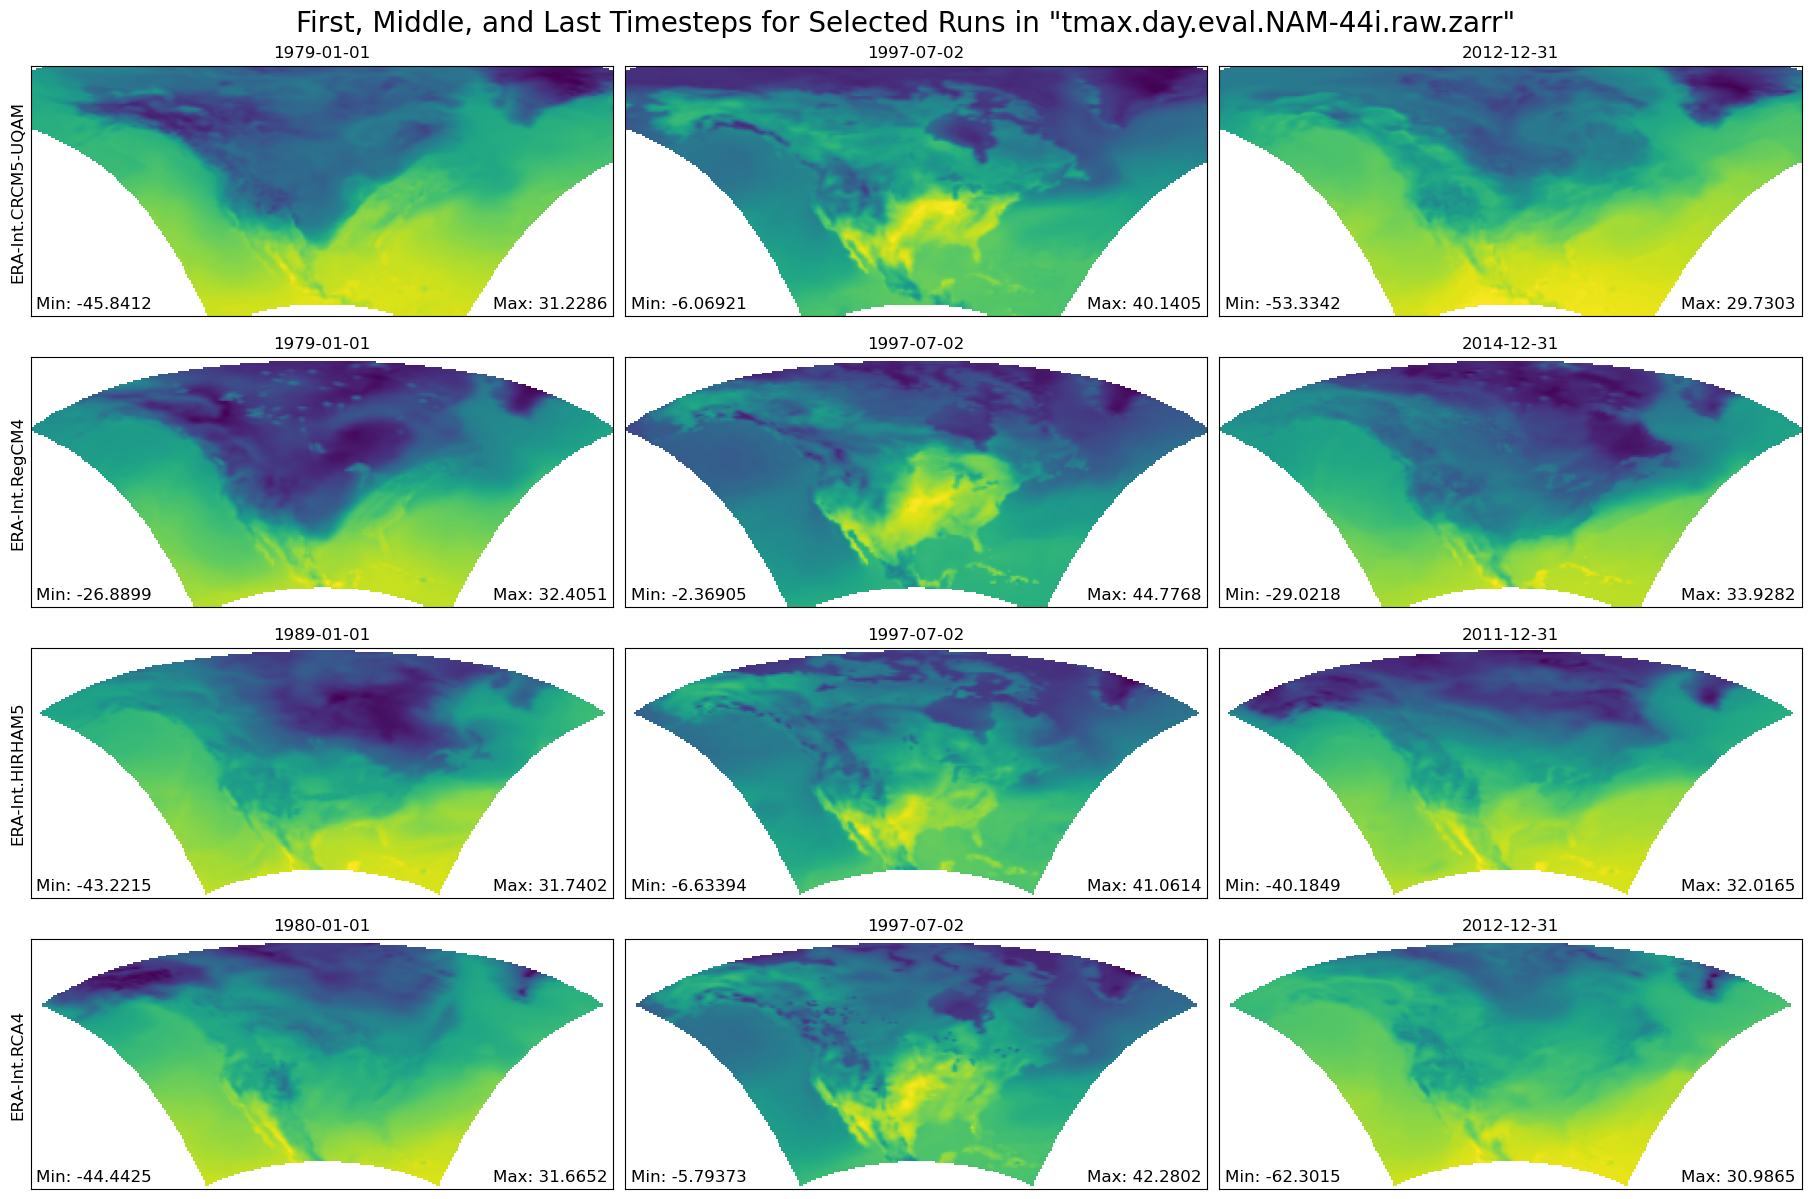

CPU times: user 10.8 s, sys: 2.49 s, total: 13.3 s
Wall time: 2min 44s


In [23]:
%%time

# Plot using the Zarr Store obtained from an earlier step in the notebook.
figure = plot_first_mid_last(ds, data_var, store_name)

plt.show()

##### Optional: Save figure to a PNG file

Change the value of `SAVE_PLOT` to True to produce a PNG file of the plot.   The file will be saved in the same folder as this notebook.

Then use Jupyter's file browser to locate the file and right-click the file to download it.   

In [24]:
SAVE_PLOT = False
if SAVE_PLOT:
    plotfile = f'./{dataset_key}_FML.png'
    figure.savefig(plotfile, dpi=100)

#### Create Statistical Map Plots for Several Output Runs (more compute intensive)

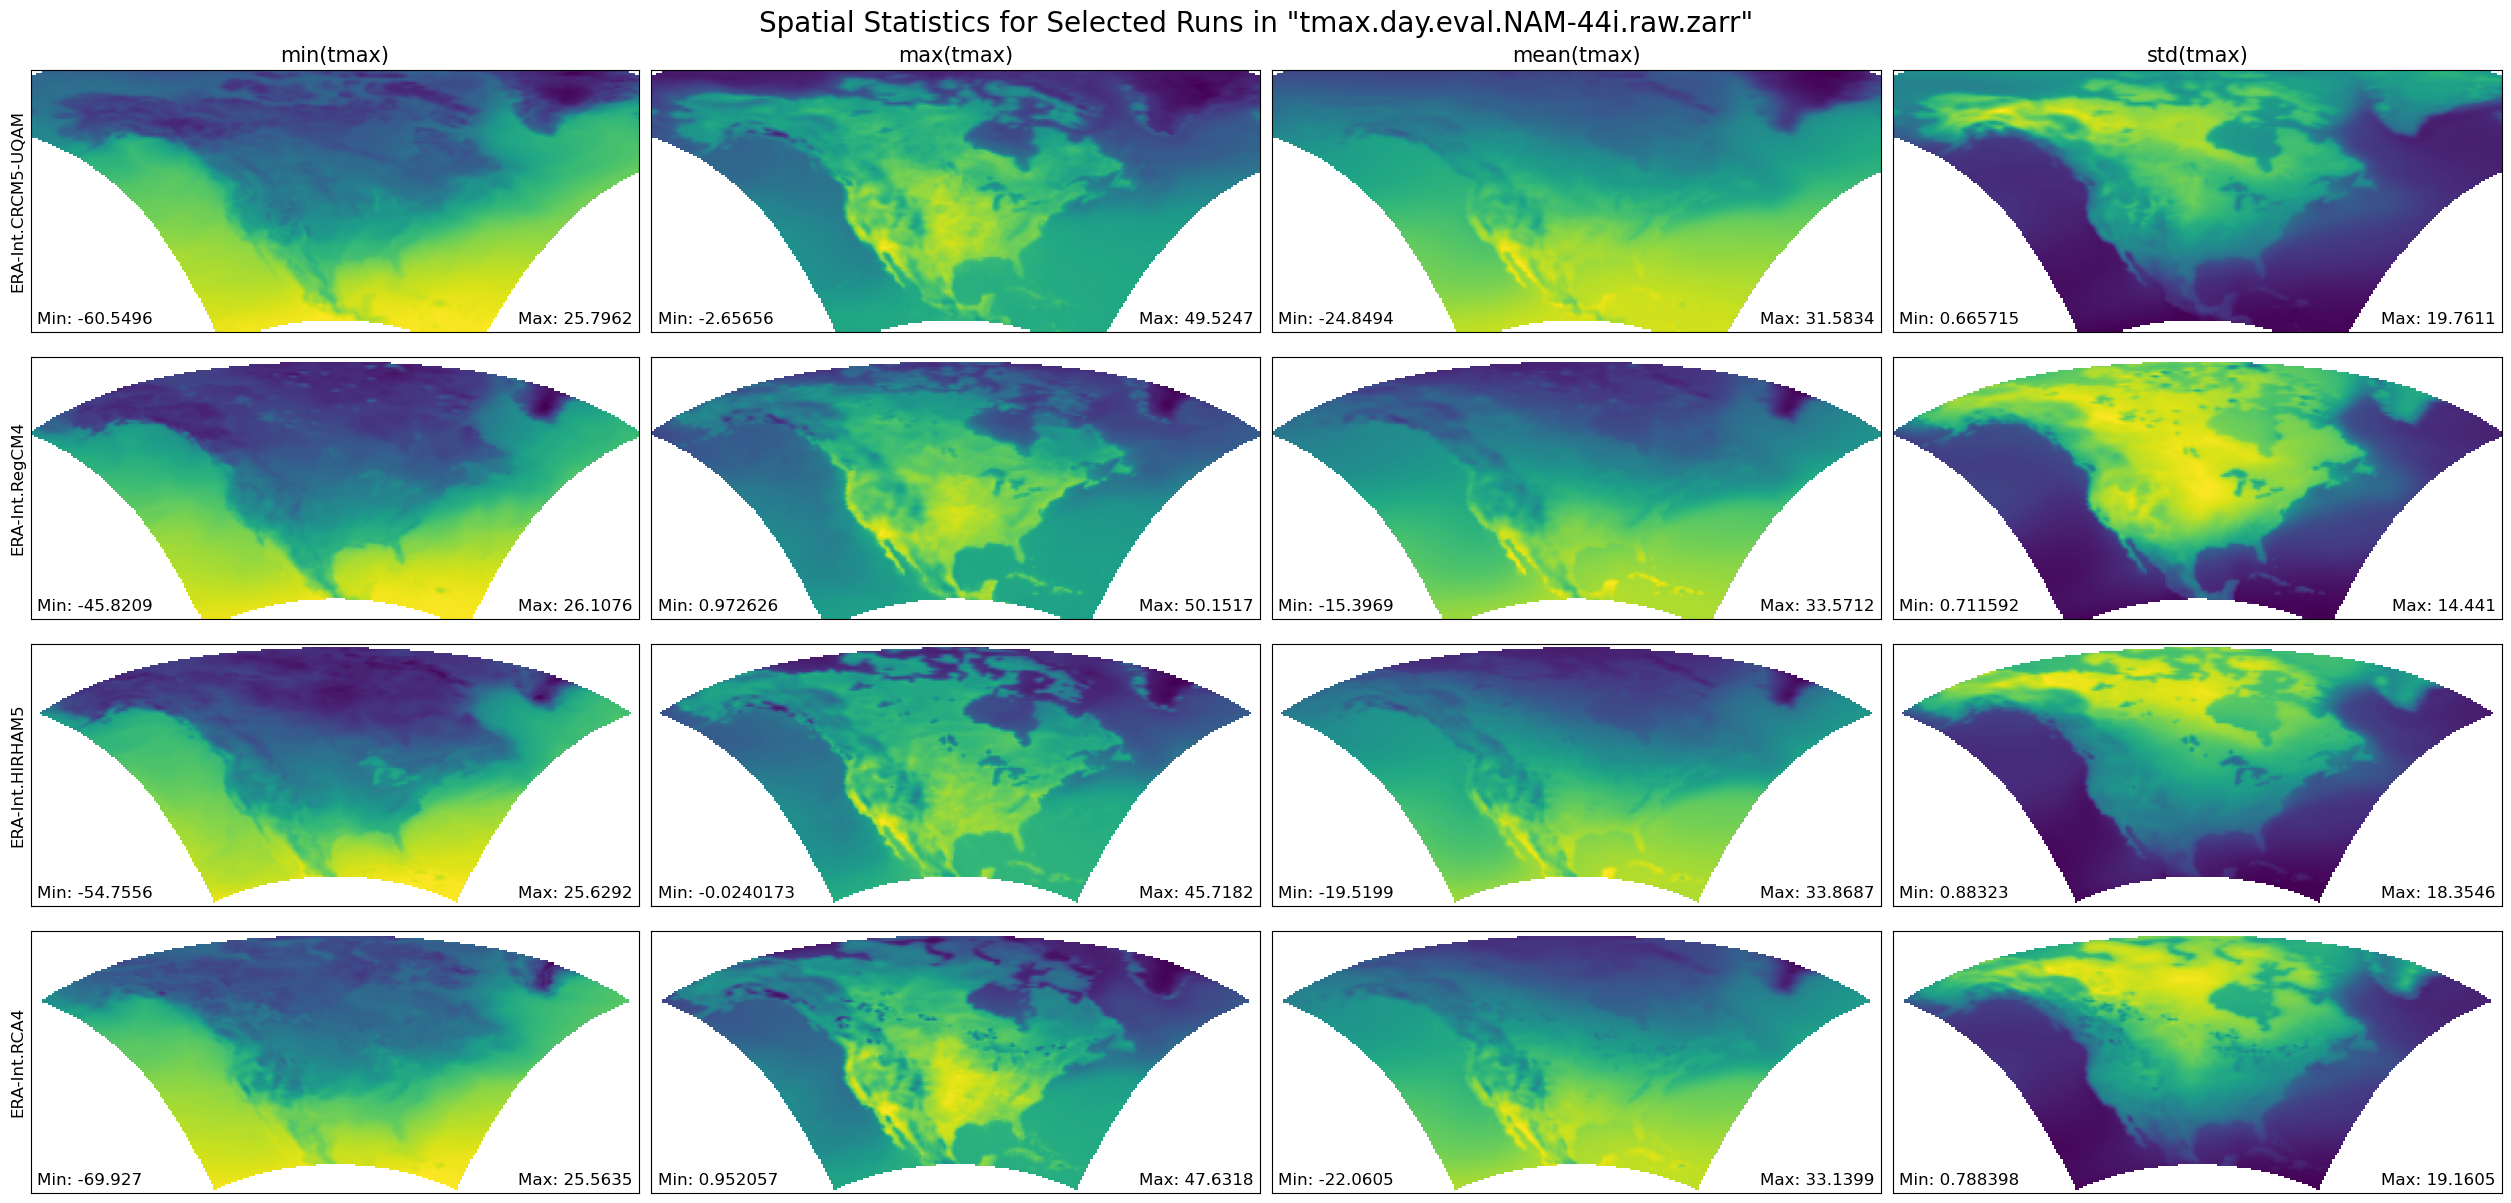

CPU times: user 7.43 s, sys: 1.65 s, total: 9.08 s
Wall time: 1min 19s


In [25]:
%%time

# Plot using the Zarr Store obtained from an earlier step in the notebook.
figure = plot_stat_maps(ds, data_var, store_name, TRUNCATE_DATA)

plt.show()

##### Optional: Save figure to a PNG file

Change the value of `SAVE_PLOT` to True to produce a PNG file of the plot.   The file will be saved in the same folder as this notebook.

Then use Jupyter's file browser to locate the file and right-click the file to download it.   

In [26]:
SAVE_PLOT = False
if SAVE_PLOT:
    plotfile = f'./{dataset_key}_MAPS.png'
    figure.savefig(plotfile, dpi=100)

#### Plot Time Series for Several Output Runs (more compute intensive)

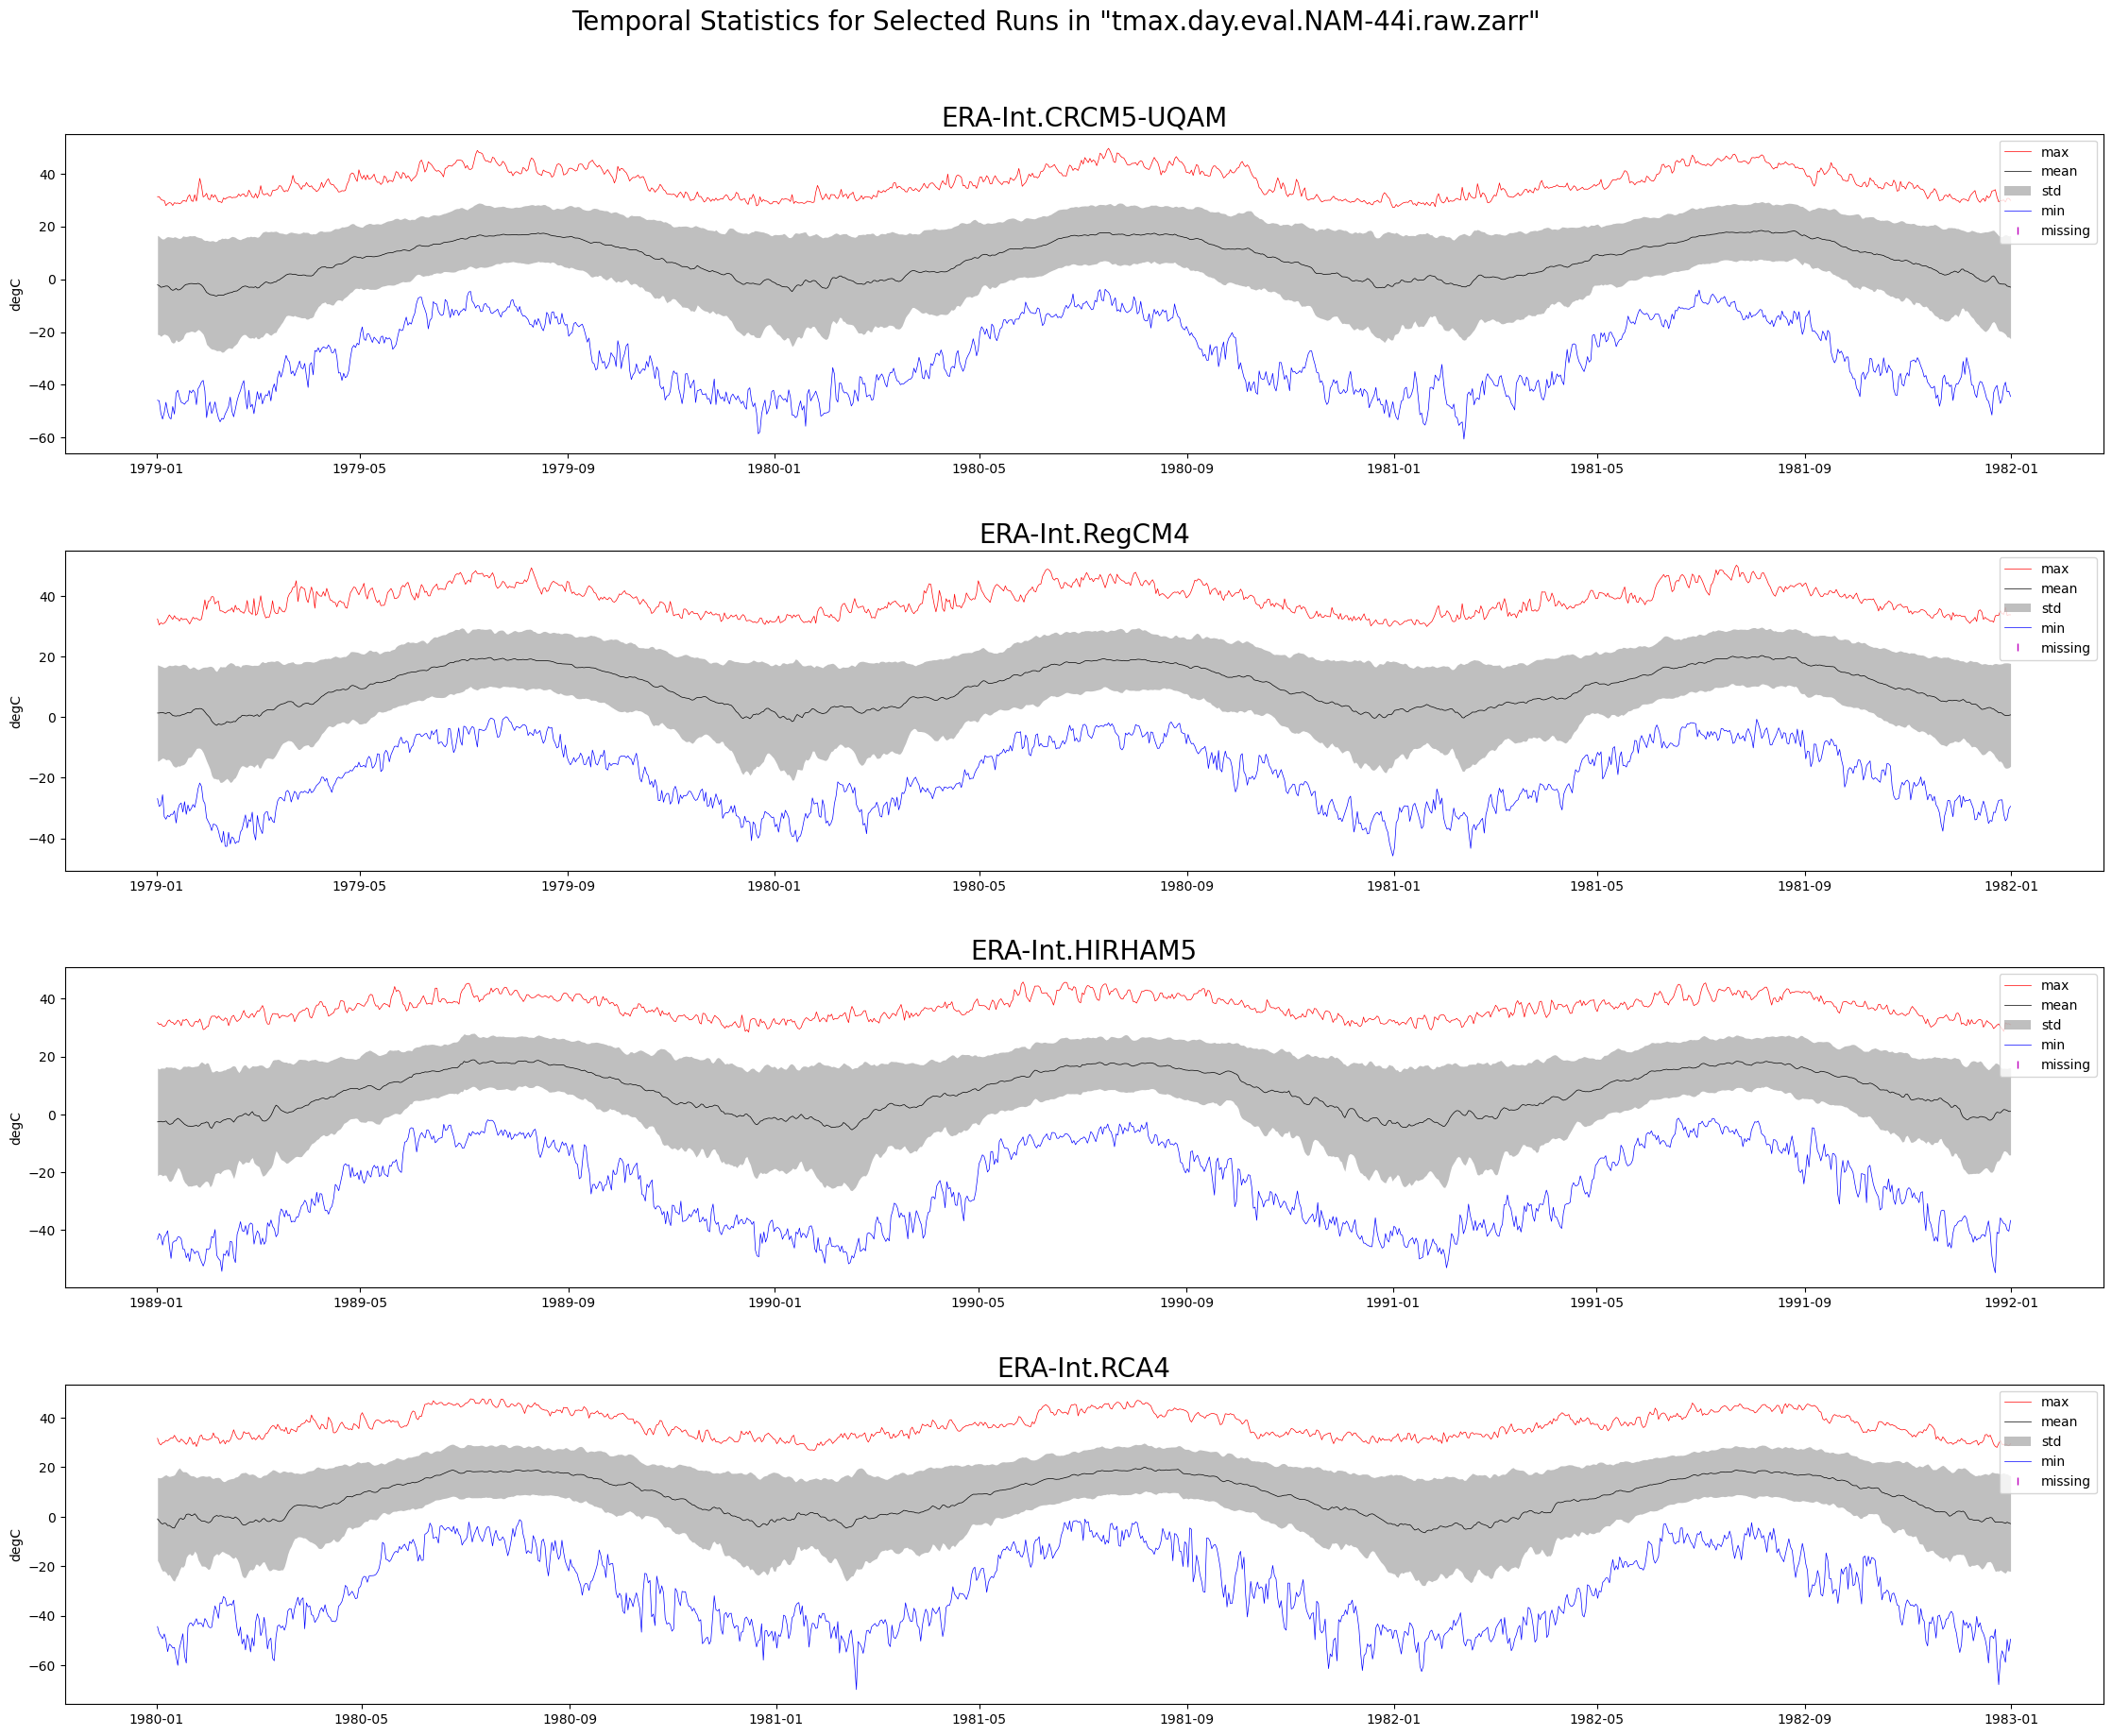

CPU times: user 8.44 s, sys: 1.57 s, total: 10 s
Wall time: 1min 42s


In [27]:
%%time

# Plot using the Zarr Store obtained from an earlier step in the notebook.
figure = plot_timeseries(ds, data_var, store_name, TRUNCATE_DATA)

plt.show()

##### Optional: Save figure to a PNG file

Change the value of `SAVE_PLOT` to True to produce a PNG file of the plot.   The file will be saved in the same folder as this notebook.

Then use Jupyter's file browser to locate the file and right-click the file to download it.   

In [28]:
SAVE_PLOT = False
if SAVE_PLOT:
    plotfile = f'./{dataset_key}_TS.png'
    figure.savefig(plotfile, dpi=100)

#### Release the workers.

In [29]:
!date

Mon Jul 31 20:28:55 UTC 2023


In [30]:
cluster.close()

#### Show which python package versions were used

In [31]:
%load_ext watermark
%watermark -iv

intake    : 0.7.0
numpy     : 1.25.0
xarray    : 2023.6.0
matplotlib: 3.7.1

